In [143]:
import warp as wp
import pyvista as pv
import numpy as np
from pyvista import CellType
from warp.types import vector
from warp import sparse
from warp.optim import linear
from typing import Any

import scipy.sparse as sp_sparse
from warp_cfd.FV.Ops.array_ops import add_1D_array,sub_1D_array,inv_1D_array,to_vector_array,mult_scalar_1D_array,absolute_1D_array,power_scalar_1D_array,sum_1D_array,L_norm_1D_array

from matplotlib import pyplot as plt
from warp_cfd.preprocess import Mesh
from FiniteVolume import FVM
import scipy as sp
from scipy.interpolate import RegularGridInterpolator,LinearNDInterpolator

In [144]:
if __name__ == '__main__':
    from grid import create_hex_grid
    
    n = 81
    w,l = 1.,1.
    G,nu = 1,0.01
    m = create_hex_grid(n,n,1,(w/n,l/n,1.))

    # IC = pouiselle_flow(m.cell_centroids,width= w,G = G, nu = nu)
    x = m.face_properties.centroid[m.groups['+Y'].ids][:,0] # x co of inlet
    inlet = G/(2*nu) * x*(x - w)
    # plt.plot(x,inlet)
    # plt.show()
    m.set_boundary_value('+X',u = 0,v = 0,w = 0) # No Slip
    m.set_boundary_value('-X',u = 0,v = 0,w = 0) # No Slip
    m.set_boundary_value('-Y',u = 0,v = 0,w = 0) # No Slip
    m.set_boundary_value('+Y',u = 1,v = 0,w = 0) # Velocity Inlet
    # m.set_boundary_value('-Y',p = 0.) # No Slip
    # m.set_boundary_value('+Y',p = 1.) # Velocity Inlet
     # m.set_boundary_value('-Y',p=0)
    '''
    Add check that All bf have some fixed value => Boundary IDs should equal same length as boundary faces
    '''

    m.set_gradient_value('-Z',u=0,v=0,w=0,p=0) # No penetration condition
    m.set_gradient_value('+Z',u=0,v=0,w=0,p=0) # No penetration condition
    m.set_gradient_value('+X',p = 0) # No Slip
    m.set_gradient_value('-X',p = 0) # No Slip
    # m.set_gradient_value('-Y',u=0,v=0,w=0) # No Slip
    m.set_gradient_value('+Y',p = 0) # Velocity Inlet
    m.set_gradient_value('-Y',p = 0) # Velocity Inlet
    m.set_cell_value(0,p= 0)
    
    model = FVM(m,density = 1.,viscosity= nu)
    model.init_step()
    results = m.pyvista_mesh

np.set_printoptions(linewidth=300,threshold=1e10,precision = 7)
    

In [145]:
centroids = model.struct_member_to_array('centroid','cells')
x,y,z = [centroids[:,i] for i in range(3)]
coords = np.load('coords.npy')
true_sol = np.load('results.npy')

x

array([0.0061728, 0.0185185, 0.0308642, 0.0432099, 0.0555556, 0.0679012, 0.0802469, 0.0925926, 0.1049383, 0.117284 , 0.1296296, 0.1419753, 0.154321 , 0.1666667, 0.1790123, 0.191358 , 0.2037037, 0.2160494, 0.2283951, 0.2407407, 0.2530864, 0.2654321, 0.2777778, 0.2901235, 0.3024691, 0.3148148,
       0.3271605, 0.3395062, 0.3518519, 0.3641975, 0.3765432, 0.3888889, 0.4012346, 0.4135802, 0.4259259, 0.4382716, 0.4506173, 0.462963 , 0.4753087, 0.4876543, 0.5      , 0.5123457, 0.5246913, 0.537037 , 0.5493827, 0.5617284, 0.5740741, 0.5864198, 0.5987654, 0.6111111, 0.6234568, 0.6358024,
       0.6481482, 0.6604939, 0.6728395, 0.6851852, 0.6975309, 0.7098765, 0.7222222, 0.7345679, 0.7469136, 0.7592593, 0.771605 , 0.7839506, 0.7962963, 0.808642 , 0.8209876, 0.8333333, 0.845679 , 0.8580247, 0.8703704, 0.8827161, 0.8950617, 0.9074074, 0.9197531, 0.9320987, 0.9444444, 0.9567901,
       0.9691358, 0.9814815, 0.9938272, 0.0061728, 0.0185185, 0.0308642, 0.0432099, 0.0555556, 0.0679012, 0.0802469, 0.09

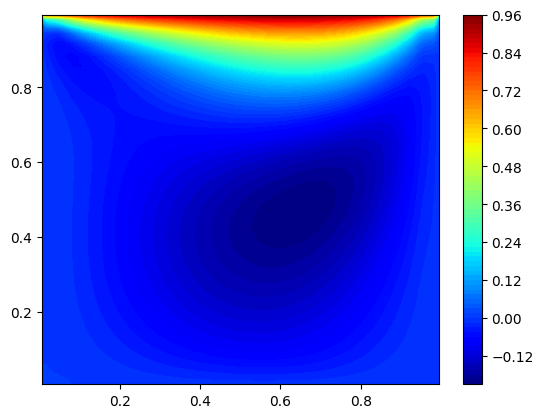

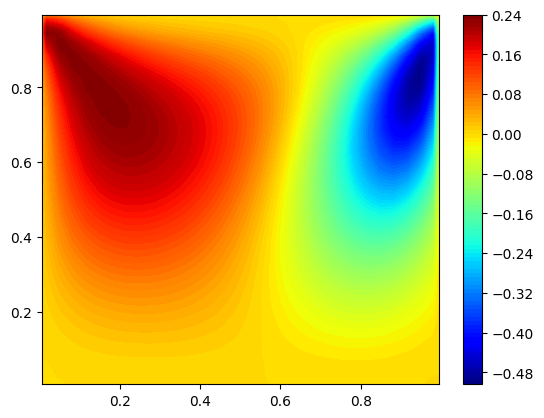

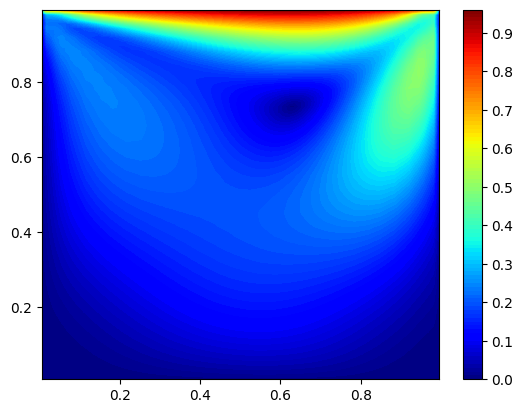

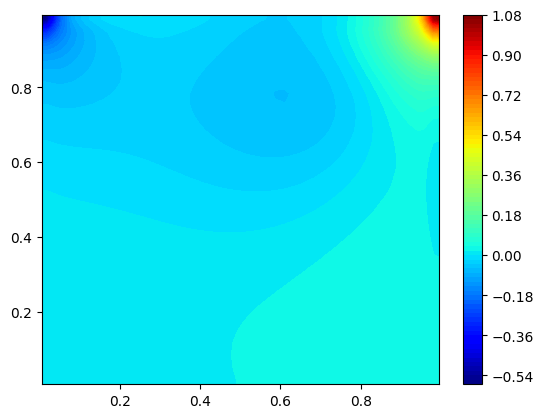

In [146]:



xx = coords[:,:,0]
yy = coords[:,:,1]
points = np.stack([xx,yy],axis = -1)
x_arrr = xx[0,:]

# u_f = LinearNDInterpolator(points = points,values = true_sol[:,:,0].flatten())
u_f = RegularGridInterpolator(points = [x_arrr,x_arrr],values = np.flipud(true_sol[:,:,0]).T)
v_f = RegularGridInterpolator(points = [x_arrr,x_arrr],values = np.flipud(true_sol[:,:,1]).T)
p_f = RegularGridInterpolator(points = [x_arrr,x_arrr],values = np.flipud(true_sol[:,:,2]).T)


points = np.stack([x,y],axis = -1)
u = u_f(points)
v = v_f(points)
p = p_f(points)

plt.tricontourf(x,y,u,cmap = 'jet',levels = 100)
plt.colorbar()
plt.show()
plt.tricontourf(x,y,v,cmap = 'jet',levels = 100)
plt.colorbar()
plt.show()
plt.tricontourf(x,y,np.sqrt(u**2+v**2),cmap = 'jet',levels = 100)
plt.colorbar()
plt.show()
plt.tricontourf(x,y,p,cmap = 'jet',levels = 100)
plt.colorbar()
plt.show()


In [163]:
mat = [
[ 0.006, -0.001,  0.,   -0.001, 0.,    0.,    0.,    0.,    0.,  ],
 [-0.001, 0.005,-0.001, 0.,   -0.001, 0.,    0.,    0.,    0.,  ],
 [ 0.,   -0.001, 0.006, 0.,    0.,   -0.001, 0.,    0.,    0.,  ],
 [-0.001, 0.,    0.,    0.005,-0.001, 0.,   -0.001, 0.,    0.,  ],
 [ 0.,   -0.001, 0.,   -0.001, 0.004, -0.001, 0.,   -0.001, 0.,  ],
 [ 0.,    0.,   -0.001, 0.,   -0.001, 0.005, 0.,    0.,   -0.001],
 [ 0.,    0.,    0.,   -0.001, 0.,    0.,    0.006,-0.001, 0.,  ],
 [ 0.,    0.,    0.,    0.,   -0.001, 0.,   -0.001, 0.005,-0.001],
 [ 0.,    0.,    0.,    0.,    0.,   -0.001, 0.,   -0.001, 0.006],]


mat = np.array(mat,dtype = np.float32)
b = np.zeros(9,dtype = np.float32)
b[-1] = 0.002
b[-2] = 0.002
b[-3] = 0.002
b

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.002, 0.002], dtype=float32)

In [ ]:
ww = np.linalg.solve(mat,b)

In [ ]:
Ax = np.matmul(mat,ww)

np.linalg.norm(Ax - b,ord = 2)/np.linalg.norm(b,ord =2 )

2.6588788e-08

In [147]:
w = np.zeros_like(u)
benchmark = np.stack([u,v,w,p],axis =-1)

np.save(f'benchmark_n{n}.npy',benchmark)

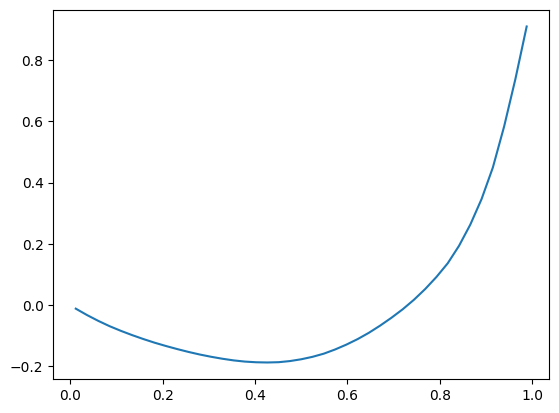

In [130]:
u_05 = u.reshape((n,n))[:,n//2]
plt.plot(y[x == 0.5],u_05)
plt.show()

In [166]:
v_05 = v.reshape((n,n))[n//2,:]
plt.plot(x[y == 0.5],v_05), max(v_05)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 6561

In [ ]:

model.MAX_STEPS = 200
for i in range(model.MAX_STEPS):
    print(model.step())

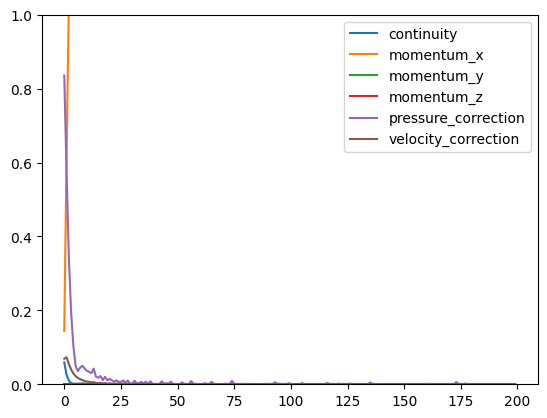

e:\py312_torch_2-5\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


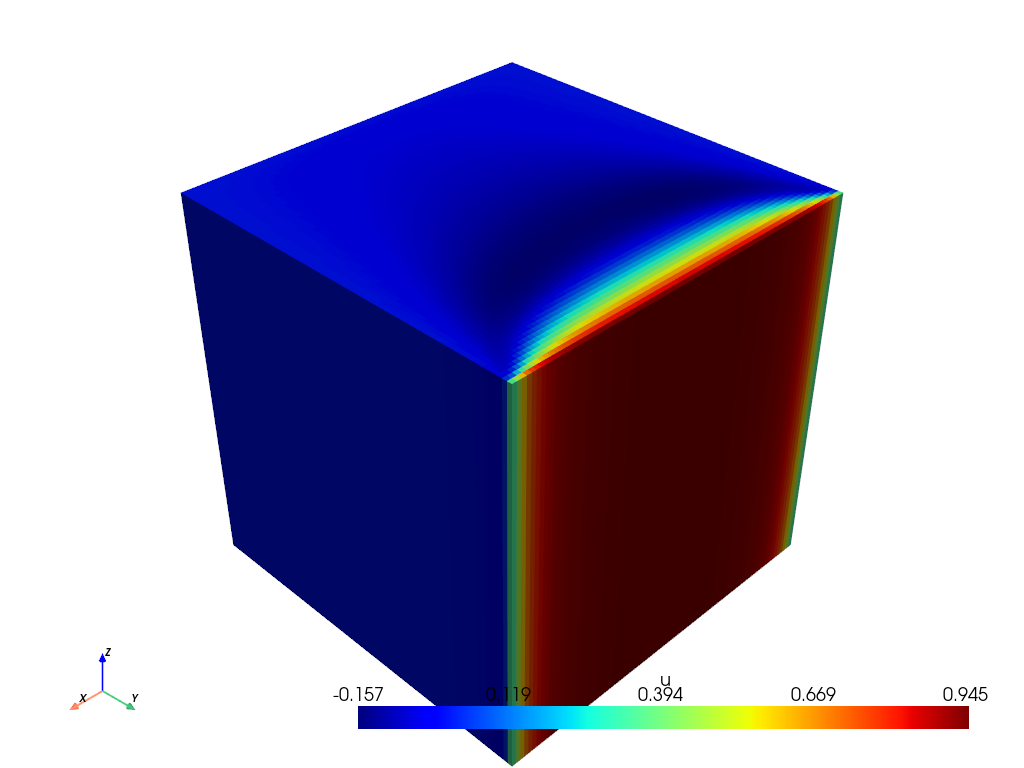

e:\py312_torch_2-5\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


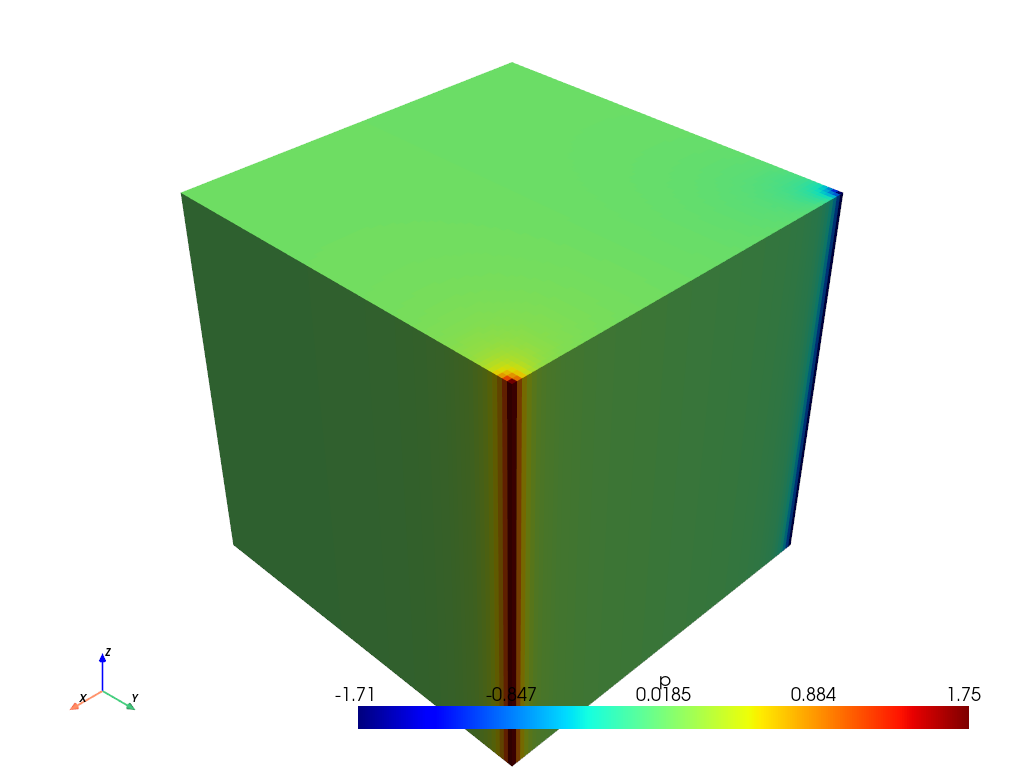

e:\py312_torch_2-5\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


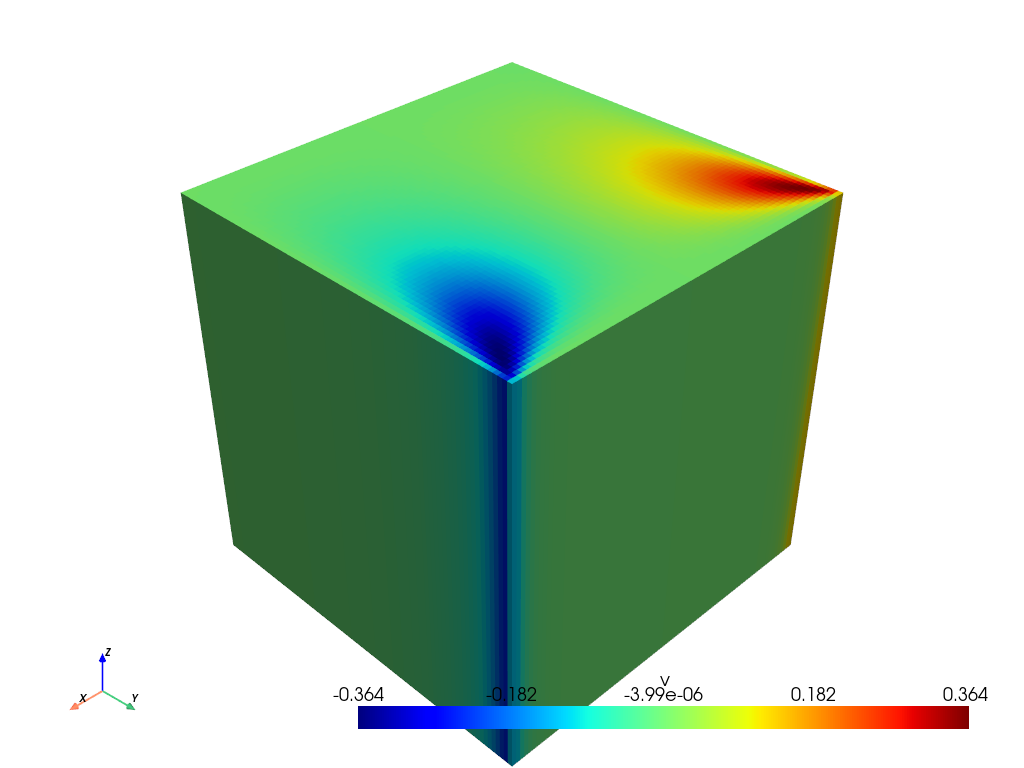

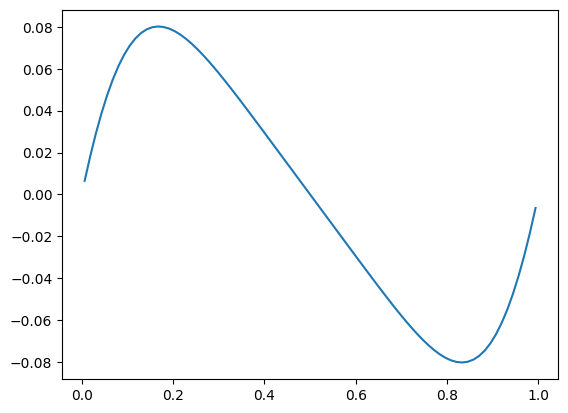

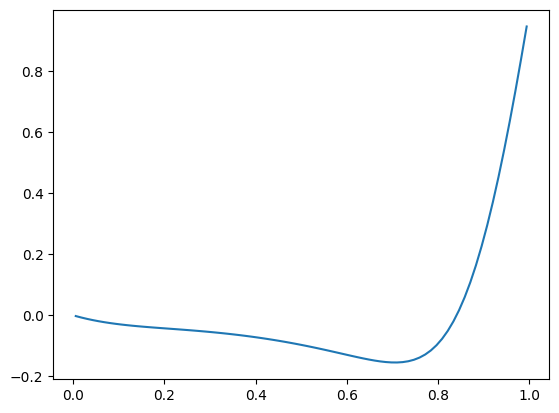

In [ ]:
p_corr_m = model.pressure_correction_step.p_correction_matrix
vel_matrix = model.intermediate_velocity_step.vel_matrix

a = model.intermediate_velocity_step
b = model.pressure_correction_step

velocity = model.corrected_velocity.numpy().reshape(-1,3)
p = model.cell_values.numpy()[:,-1]
u = velocity[:,0]
v = velocity[:,1]
z = velocity[:,2]

results = m.pyvista_mesh
# print(model.p.shape)
results.cell_data['p'] = model.pressure_correction_step.p.numpy()
results.cell_data['u'] = u
results.cell_data['v'] = v
results.cell_data['umag'] = np.sqrt(v**2 + u**2)

results.cell_data['div u'] = b.div_u.numpy()
results.cell_data['cell id'] = np.arange(model.num_cells)
results.cell_data['dudy'] = model.cell_gradients.numpy()[:,0,1]


centroids = model.struct_member_to_array('centroid','cells')
x,y,z = [centroids[:,i].reshape(n,n) for i in range(3)]
# print()

p_corr = model.pressure_correction_step.p_correction.numpy()
results.cell_data['p_corr'] = p_corr
# model.Convergence.plot_residuals()

results.cell_data['res'] = model.res
# results.plot(scalars="cell id", cmap="jet", show_scalar_bar=True)
# results.plot(scalars="dudy", cmap="jet", show_scalar_bar=True)
# results.plot(scalars='res', cmap="jet",show_scalar_bar=True)
# results.plot(scalars="u", cmap="jet", show_scalar_bar=True)
# results.plot(scalars="p", cmap="jet", show_scalar_bar=True)
# results.plot(scalars="v", cmap="jet", show_scalar_bar=True)





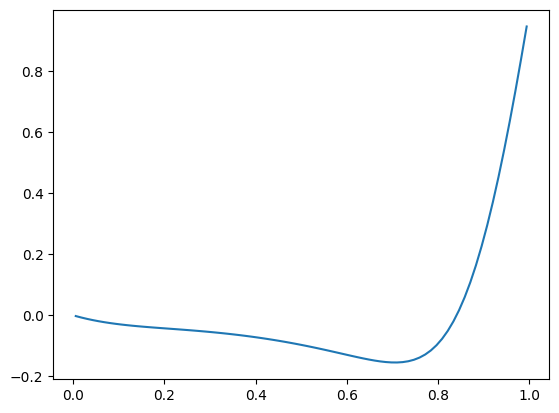

In [34]:
x,y,z = [centroids[:,i] for i in range(3)]

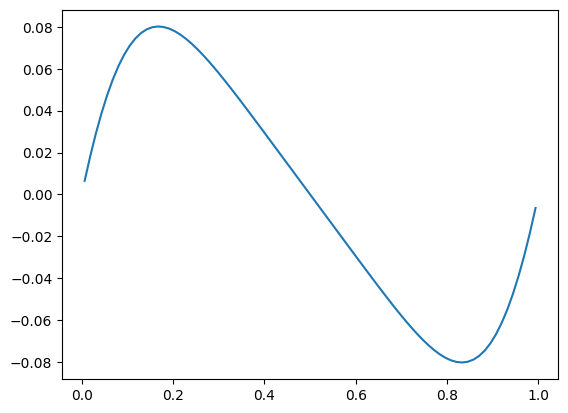

In [41]:
v_05 = v[y == 0.5]
plt.plot(x[y == 0.5],v_05)

In [28]:
y[n//2]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)

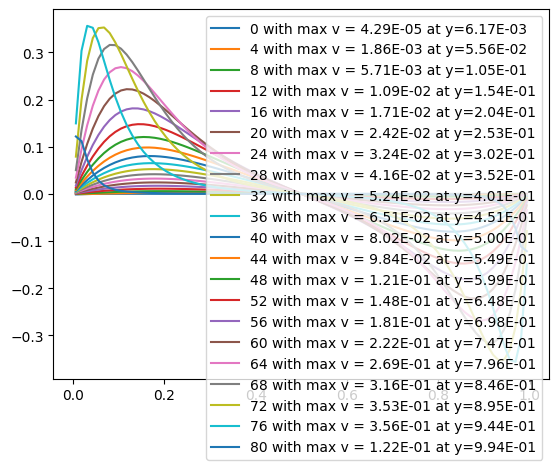

In [30]:
for i in range(0,n,4):
    v_05 = v.reshape((n,n))[i,:]
    max_v = v_05.max()
    y_loc = y[i,0]
    plt.plot(x[n//2],v_05,label = f'{i} with max v = {max_v:.2E} at y={y_loc:.2E}')
plt.legend()
plt.show()

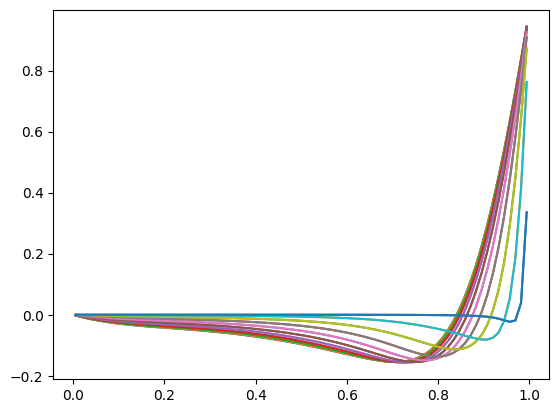

In [33]:
for i in range(0,n,4):
    u_05 = u.reshape((n,n))[:,i]
    max_v = u_05.max()
    x_loc = x[0,i]
    plt.plot(x[n//2],u_05,label = f'{i} with max v = {max_v:.2E} at x={x_loc:.2E}')
# plt.legend()
plt.show()

In [11]:
y[n//2]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)